# FHE on sentiment analysis using xgboost on TF-IDf and Transformers.ipynb



###Installation and importing the dataset for sentiment analysis

In [1]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 397, in resolve
    self._ad

In [2]:
# @title
import os
import time

import numpy
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split

from concrete.ml.sklearn import XGBClassifier


ModuleNotFoundError: No module named 'concrete'

In [ ]:
# @title
!wget -O Tweets.csv https://huggingface.co/datasets/osanseviero/twitter-airline-sentiment/resolve/main/Tweets.csv

###Data pre-processing and exploration

In [ ]:
train = pd.read_csv("Tweets.csv", index_col=0)
text_X = train["text"]
y = train["airline_sentiment"]
y = y.replace(["negative", "neutral", "positive"], [0, 1, 2])

pos_ratio = y.value_counts()[2] / y.value_counts().sum()
neg_ratio = y.value_counts()[0] / y.value_counts().sum()
neutral_ratio = y.value_counts()[1] / y.value_counts().sum()
print(f"Proportion of positive examples: {round(pos_ratio * 100, 2)}%")
print(f"Proportion of negative examples: {round(neg_ratio * 100, 2)}%")
print(f"Proportion of neutral examples: {round(neutral_ratio * 100, 2)}%")


In [ ]:
# Split in train test
text_X_train, text_X_test, y_train, y_test = train_test_split(
    text_X, y, test_size=0.1, random_state=42
)

###XGBoost on TF-IDF encoding

In [ ]:
# Let's first build a representation vector from the text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
X_train = tfidf_vectorizer.fit_transform(text_X_train)
X_test = tfidf_vectorizer.transform(text_X_test)

# Make our train and test dense array
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
# Let's build our model
model = XGBClassifier()

# A gridsearch to find the best parameters
parameters = {
    "n_bits": [2, 3],
    "max_depth": [1],
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
}

In [ ]:
grid_search = GridSearchCV(model, parameters, cv=3, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=1,
             param_grid={'max_depth': [1], 'n_bits': [2, 3],
                         'n_estimators': [10, 30, 50], 'n_jobs': [-1]},
             scoring='accuracy')

In [ ]:
# Check the accuracy of the best model
# print(f"Best score: {grid_search.best_score_}")

# # Check best hyper-parameters
# print(f"Best parameters: {grid_search.best_params_}")
# print (grid_search.best_estimator_)
# # Extract best model
best_model = XGBClassifier(n_bits=4)
best_model.fit(X_train, y_train)


XGBClassifier(n_bits=4)

In [ ]:
# Compute the average precision for each class
y_proba_test_tfidf = best_model.predict_proba(X_test)

# Compute accuracy
y_pred_test_tfidf = numpy.argmax(y_proba_test_tfidf, axis=1)
accuracy_tfidf = numpy.mean(y_pred_test_tfidf == y_test)
print(f"Accuracy: {accuracy_tfidf:.4f}")

y_pred_positive = y_proba_test_tfidf[:, 2]
y_pred_negative = y_proba_test_tfidf[:, 0]
y_pred_neutral = y_proba_test_tfidf[:, 1]

ap_positive_tfidf = average_precision_score((y_test == 2), y_pred_positive)
ap_negative_tfidf = average_precision_score((y_test == 0), y_pred_negative)
ap_neutral_tfidf = average_precision_score((y_test == 1), y_pred_neutral)

print(f"Average precision score for positive class: " f"{ap_positive_tfidf:.4f}")
print(f"Average precision score for negative class: " f"{ap_negative_tfidf:.4f}")
print(f"Average precision score for neutral class: " f"{ap_neutral_tfidf:.4f}")

Accuracy: 0.7227
Average precision score for positive class: 0.6644
Average precision score for negative class: 0.8898
Average precision score for neutral class: 0.4540


In [ ]:
# Let's see what are the top predictions based on the probabilities in y_pred_test
print("5 most positive tweets (class 2):")
for i in range(5):
    print(text_X_test.iloc[y_proba_test_tfidf[:, 2].argsort()[-1 - i]])

print("-" * 100)

print("5 most negative tweets (class 0):")
for i in range(5):
    print(text_X_test.iloc[y_proba_test_tfidf[:, 0].argsort()[-1 - i]])

5 most positive tweets (class 2):
@SouthwestAir I continue to be amazed by the amazing customer service.  Thank you SWA!
@JetBlue Awesome thanks! Thanks for the quick response. You guys ROCK! :)
@JetBlue I do! The best airline wifi ever. Thank you!
@AmericanAir Great, thanks. Followed.
@SouthwestAir AMAZING c/s today by SW thank you SO very much. This is the reason we fly you #southwest
----------------------------------------------------------------------------------------------------
5 most negative tweets (class 0):
@USAirways been on hold 2 hours for a Cancelled Flighted flight. I understand the delay. I don't understand you auto-reFlight Booking Problems me on TUESDAY. HELP!
@SouthwestAir 2 hours on hold for customer service never us SW again
@USAirways nothing like back to back delayed flights let hope this one isn't 12 hours like the last time.
@USAirways - I wouldn't need to wait on hold for 6+ hours if your website worked correctly - please respond!
@USAirways @AmericanAir on 

In [ ]:
# Compile the model to get the FHE inference engine
# (this may take a few minutes depending on the selected model)
import time
start = time.perf_counter()
best_model.compile(X_train)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")

# Let's write a custom example and predict in FHE
tested_tweet = ["AirFrance is awesome"]
X_tested_tweet = tfidf_vectorizer.transform(numpy.array(tested_tweet)).toarray()
clear_proba = best_model.predict_proba(X_tested_tweet)

# Now let's predict with FHE over a single tweet and print the time it takes
start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_tested_tweet, fhe="disable")
end = time.perf_counter()
print(f"FHE inference time: {end - start:.4f} seconds")

Compilation time: 54.1954 seconds
FHE inference time: 0.0112 seconds


In [ ]:
# Compile the model to get the FHE inference engine
# (this may take a few minutes depending on the selected model)
start = time.perf_counter()
best_model.compile(X_train)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")

# Let's write a custom example and predict in FHE
tested_tweet = ["AirFrance is awesome"]
X_tested_tweet = tfidf_vectorizer.transform(numpy.array(tested_tweet)).toarray()
clear_proba = best_model.predict_proba(X_tested_tweet)

# Now let's predict with FHE over a single tweet and print the time it takes
start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_tested_tweet, fhe="simulate")
end = time.perf_counter()
print(f"FHE inference time: {end - start:.4f} seconds")

AttributeError: 'float' object has no attribute 'perf_counter'

In [ ]:
print(f"Probabilities from the FHE inference: {decrypted_proba}")
print(f"Probabilities from the unencrypted model: {clear_proba}")
#probabilities are positive, negative and neutral

Probabilities from the FHE inference: [[0.35848424 0.15339904 0.48811671]]
Probabilities from the unencrypted model: [[0.35848424 0.15339904 0.48811671]]


In [ ]:
#We trained a XGBoost model over TF-IDF representation of the tweets and their respective sentiment class.
#The grid search gives us a model that achieves around ~70% accuracy.
#Given the imbalance in the classes, we rather compute the average precision per class.
#In this notebook we presented TF-IDF vectorization to represent a text.
#Then used this representation to train a machine learning model will run in FHE (here XGBoost)

#Once the model is trained, clients can send encrypted text representation to the server to get a sentiment analysis done and they receive the probability for each class (negative, neutral and positive) in an encrypted format which can then be decrypted by the client. For now, all the FHE magic (encrypt, predict and decrypt) is done within the predict_proba function with the argument fhe='execute'. In the next release, an API will be provided to split the server/client parts.

In [ ]:
%matplotlib inline
# Let's print the results obtained in this notebook
df_results = pd.DataFrame(
    {
        "Model": ["TF-IDF + XGBoost"],
        "Accuracy": [accuracy_tfidf],
        "Average Precision (positive)": [
            ap_positive_tfidf
        ],
        "Average Precision (negative)": [
            ap_negative_tfidf
        ],
        "Average Precision (neutral)": [
            ap_neutral_tfidf
        ],
    }
)
df_results.set_index("Model", inplace=True)
df_results  # pylint: disable=pointless-statement

,Accuracy,Average Precision (positive),Average Precision (negative),Average Precision (neutral)
Model,,,,
TF-IDF + XGBoost,0.722678,0.664428,0.889792,0.454011


###Graphing accuracy and time with number of bits

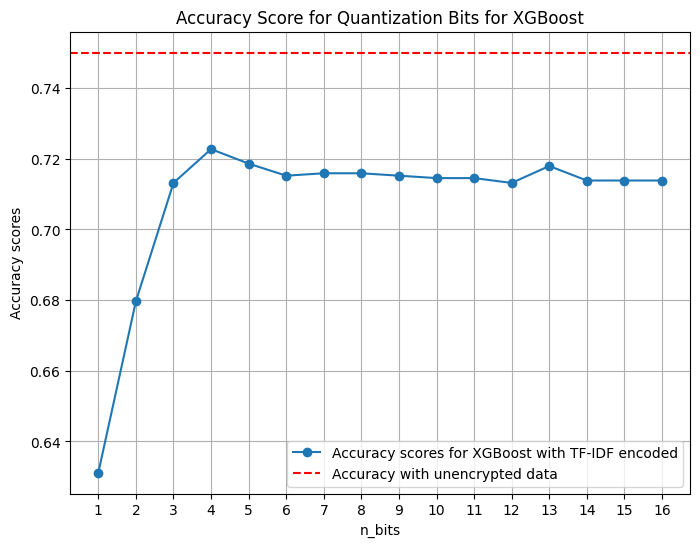

In [ ]:
n_bits_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Example values for n_bits
accuracy_scores = []
mse_scores = []
times = []

for n_bits in n_bits_values:
    # Train conLinearRegression model with different n_bits values
    model = XGBClassifier(n_bits=n_bits)
    model.fit(X_train, y_train)


    y_proba_test_tfidf = model.predict_proba(X_test)

  # Compute accuracy

    y_pred_test_tfidf = numpy.argmax(y_proba_test_tfidf, axis=1)
    start = time.perf_counter()
    accuracy_tfidf = numpy.mean(y_pred_test_tfidf == y_test)
    end = time.perf_counter()
    time1 = end - start

    # Calculate R^2 and MSE scores
    accuracy_tfidf = numpy.mean(y_pred_test_tfidf == y_test)



    accuracy_scores.append(accuracy_tfidf)
    times.append(time1)


# Plotting R^2 scores
plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, accuracy_scores, marker='o', label='Accuracy scores for XGBoost with TF-IDF encoded')
plt.axhline(y=0.75, color='r', linestyle='--', label='Accuracy with unencrypted data')
plt.xlabel('n_bits')
plt.ylabel('Accuracy scores')
plt.title('Accuracy Score for Quantization Bits for XGBoost')
plt.xticks(n_bits_values)  # Set actual values on x-axis
plt.legend()
plt.grid(True)
plt.show()

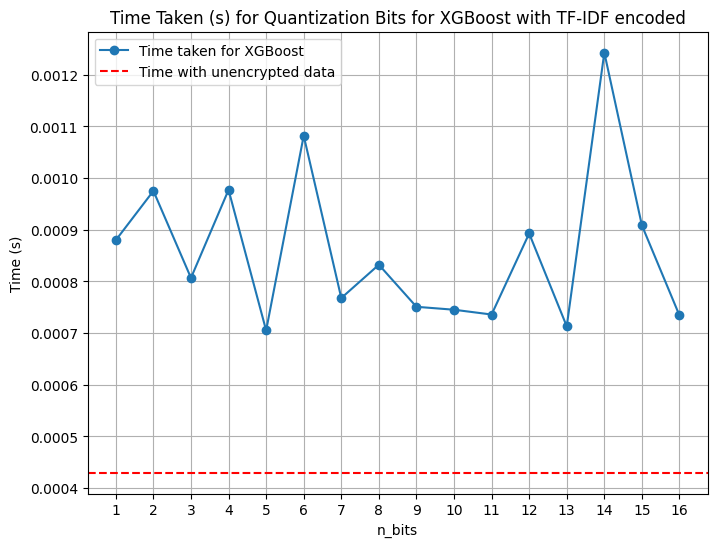

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, times, marker='o', label='Time taken for XGBoost')
plt.axhline(y=0.00043, color='r', linestyle='--', label='Time with unencrypted data')
plt.xlabel('n_bits')
plt.ylabel('Time (s)')
plt.title('Time Taken (s) for Quantization Bits for XGBoost with TF-IDF encoded')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()

###XGBoost on Transformer encoding

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
import torch
import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the tokenizer (converts text to tokens)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the pre-trained model
transformer_model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment-latest"
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def text_to_tensor(
    list_text_X_train: list,
    transformer_model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    device: str,
) -> numpy.ndarray:
    # Tokenize each text in the list one by one
    tokenized_text_X_train_split = []
    for text_x_train in list_text_X_train:
        tokenized_text_X_train_split.append(tokenizer.encode(text_x_train, return_tensors="pt"))

    # Send the model to the device
    transformer_model = transformer_model.to(device)
    output_hidden_states_list = []

    for tokenized_x in tqdm.tqdm(tokenized_text_X_train_split):
        # Pass the tokens through the transformer model and get the hidden states
        # Only keep the last hidden layer state for now
        output_hidden_states = transformer_model(tokenized_x.to(device), output_hidden_states=True)[
            1
        ][-1]
        # Average over the tokens axis to get a representation at the text level.
        output_hidden_states = output_hidden_states.mean(dim=1)
        output_hidden_states = output_hidden_states.detach().cpu().numpy()
        output_hidden_states_list.append(output_hidden_states)

    return numpy.concatenate(output_hidden_states_list, axis=0)


# Let's vectorize the text using the transformer
list_text_X_train = text_X_train.tolist()
list_text_X_test = text_X_test.tolist()

X_train_transformer = text_to_tensor(list_text_X_train, transformer_model, tokenizer, device)
X_test_transformer = text_to_tensor(list_text_X_test, transformer_model, tokenizer, device)


100%|██████████| 1464/1464 [04:11<00:00,  5.83it/s]


In [ ]:
grid_search = GridSearchCV(model, parameters, cv=3, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train_transformer, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(n_bits=16), n_jobs=1,
             param_grid={'max_depth': [1], 'n_bits': [2, 3],
                         'n_estimators': [10, 30, 50], 'n_jobs': [-1]},
             scoring='accuracy')

In [ ]:
print(f"Best score: {grid_search.best_score_}")

# Check best hyper-parameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_

Best score: 0.8379629629629629
Best parameters: {'max_depth': 1, 'n_bits': 3, 'n_estimators': 50, 'n_jobs': -1}


In [ ]:
# Compute the metrics for each class

y_proba = best_model.predict_proba(X_test_transformer)

# Compute the accuracy
y_pred = numpy.argmax(y_proba, axis=1)
accuracy_transformer_xgboost = numpy.mean(y_pred == y_test)
print(f"Accuracy: {accuracy_transformer_xgboost:.4f}")

y_pred_positive = y_proba[:, 2]
y_pred_negative = y_proba[:, 0]
y_pred_neutral = y_proba[:, 1]

ap_positive_transformer_xgboost = average_precision_score((y_test == 2), y_pred_positive)
ap_negative_transformer_xgboost = average_precision_score((y_test == 0), y_pred_negative)
ap_neutral_transformer_xgboost = average_precision_score((y_test == 1), y_pred_neutral)

print(f"Average precision score for positive class: " f"{ap_positive_transformer_xgboost:.4f}")
print(f"Average precision score for negative class: " f"{ap_negative_transformer_xgboost:.4f}")
print(f"Average precision score for neutral class: " f"{ap_neutral_transformer_xgboost:.4f}")


Accuracy: 0.8463
Average precision score for positive class: 0.8959
Average precision score for negative class: 0.9647
Average precision score for neutral class: 0.7449


In [ ]:
# Get probabilities predictions in clear
y_pred_test = best_model.predict_proba(X_test_transformer)

# Let's see what are the top predictions based on the probabilities in y_pred_test
print("5 most positive tweets (class 2):")
for i in range(5):
    print(text_X_test.iloc[y_pred_test[:, 2].argsort()[-1 - i]])

print("-" * 100)

print("5 most negative tweets (class 0):")
for i in range(5):
    print(text_X_test.iloc[y_pred_test[:, 0].argsort()[-1 - i]])

5 most positive tweets (class 2):
@united I think this is the best first class I have ever gotten!!  Denver to LAX and it's wonderful!!!
@AmericanAir Flight 236 was great. Fantastic cabin crew. A+ landing. #thankyou #JFK http://t.co/dRW08djHAI
@SouthwestAir Jason (108639) at Gate #3 in SAN made my afternoon!!! #southwestairlines #stellarservice #thanks!
@SouthwestAir love them! Always get the best deals!
@AmericanAir simply amazing. Smiles for miles.Thank u for my upgrade tomorrow for ORD.We are spending a lot of time together next few weeks!
----------------------------------------------------------------------------------------------------
5 most negative tweets (class 0):
@united first you lost all my bags, now you Cancelled Flight my flight home. 30 min wait to talk to somebody #poorservice #notgoodenough
@USAirways Not only did u lose the flight plan! Now ur flight crew is FAA timed out! Thx for havin us sit on the tarmac for an hr! #Pathetic
@AmericanAir Phone just disconnects if

In [ ]:
# Compile the model to get the FHE inference engine
start = time.perf_counter()
best_model.compile(X_train_transformer)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")


# Let's write an example and predict in FHE
tested_tweet = ["AirFrance is awesome, almost as much as Zama!"]
X_tested_tweet = text_to_tensor(tested_tweet, transformer_model, tokenizer, device)
clear_proba = best_model.predict_proba(X_tested_tweet)

# Now let's predict with FHE over a single tweet and print the time it takes
start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_tested_tweet, fhe="execute")
end = time.perf_counter()
fhe_exec_time = end - start
print(f"FHE inference time: {fhe_exec_time:.4f} seconds")

Compilation time: 27.0262 seconds


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


FHE inference time: 10.5570 seconds


In [ ]:
print(f"Probabilities from the FHE inference: {decrypted_proba}")
print(f"Probabilities from the clear model: {clear_proba}")

Probabilities from the FHE inference: [[0.05162184 0.04558276 0.90279541]]
Probabilities from the clear model: [[0.05162184 0.04558276 0.90279541]]


In [ ]:
%matplotlib inline
# Let's print the results obtained in this notebook
df_results = pd.DataFrame(
    {
        "Model": ["TF-IDF + XGBoost", "Transformer + XGBoost"],
        "Accuracy": [accuracy_tfidf, accuracy_transformer_xgboost],
        "Average Precision (positive)": [
            ap_positive_tfidf,
            ap_positive_transformer_xgboost,
        ],
        "Average Precision (negative)": [
            ap_negative_tfidf,
            ap_negative_transformer_xgboost,
        ],
        "Average Precision (neutral)": [
            ap_neutral_tfidf,
            ap_neutral_transformer_xgboost,
        ],
    }
)
df_results.set_index("Model", inplace=True)


In [ ]:
df_results

,Accuracy,Average Precision (positive),Average Precision (negative),Average Precision (neutral)
Model,,,,
TF-IDF + XGBoost,0.713798,0.664428,0.889792,0.454011
Transformer + XGBoost,0.846311,0.895933,0.964674,0.744890


In [ ]:
n_bits_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] # Example values for n_bits
accuracy_scores = []
mse_scores = []
times =[]

for n_bits in n_bits_values:
    # Train conLinearRegression model with different n_bits values
    model = XGBClassifier(n_bits=n_bits)
    model.fit(X_train_transformer, y_train)


    y_proba_test_transformer = model.predict_proba(X_test_transformer)

  # Compute accuracy
    y_pred_test_transformer = numpy.argmax(y_proba_test_transformer, axis=1)
    start = time.perf_counter()

    accuracy_trans = numpy.mean(y_pred_test_transformer == y_test)
    end = time.perf_counter()
    time1 = end - start
    # Calculate R^2 and MSE scores

    accuracy_scores.append(accuracy_trans)
    times.append(time1)




###Graphing accuracy and time with number of bits

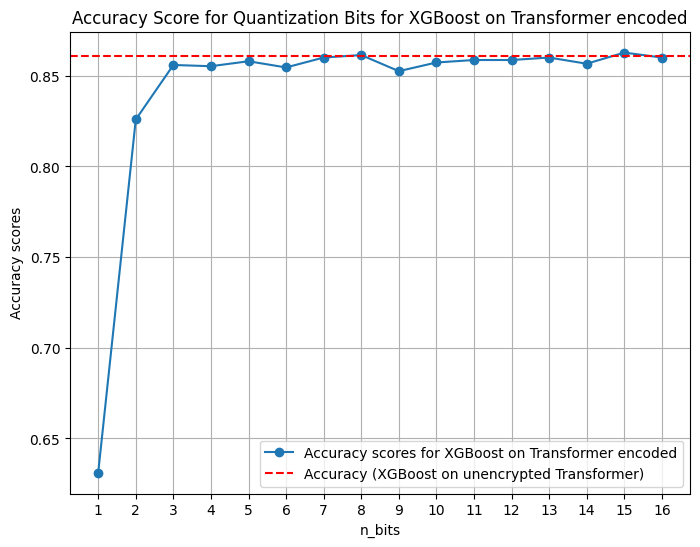

In [ ]:
# Plotting R^2 scores
plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, accuracy_scores, marker='o', label='Accuracy scores for XGBoost on Transformer encoded')
plt.axhline(y=0.861, color='r', linestyle='--', label='Accuracy (XGBoost on unencrypted Transformer)')
# plt.axhline(y=r2_score(y_test, y_pred_clear), color='r', linestyle='--', label='R2 (LinearRegression sklearn)')
plt.xlabel('n_bits')
plt.ylabel('Accuracy scores')
plt.title('Accuracy Score for Quantization Bits for XGBoost on Transformer encoded')
plt.xticks(n_bits_values)  # Set actual values on x-axis
plt.legend()
plt.grid(True)
plt.show()

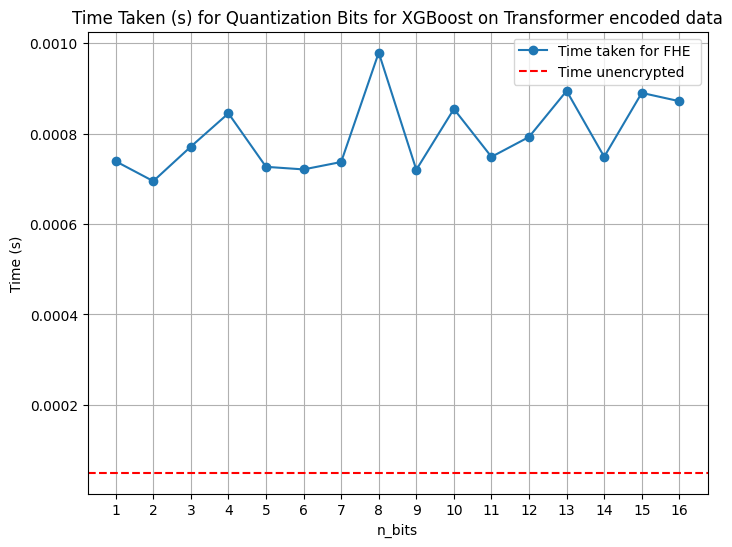

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, times, marker='o', label='Time taken for FHE ')
plt.axhline(y=0.00005, color='r', linestyle='--', label='Time unencrypted')
plt.xlabel('n_bits')
plt.ylabel('Time (s)')
plt.title('Time Taken (s) for Quantization Bits for XGBoost on Transformer encoded data')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()